# Probing the Relationship between Average Regional Temperature, Dewpoint, and Daily Percent Changes in Total Confirmed nCOVID-19 cases

### Data Sources: 
**nCOVID-19 cases**

Johns Hopkins Center for Systems Science and Engineering. (2020). _Coronavirus COVID-19 Global Cases._ Retrieved on March 15, 2020 from https://github.com/CSSEGISandData/COVID-19/raw/4297d6d4ff566d652874ee41adafd0a5525ed47a/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv 

**Daily Average Climate data**

User Engagement and Services Branch, National Climatic Data Center, NESDIS, NOAA, U.S. Department of Commerce. (2020). _Global Surface Summary of the Day._ Retrieved on March 22, 2020 from ftp://ftp.ncdc.noaa.gov/pub/data/gsod/2020/gsod_2020.tar

**GeoJSON shapefile of province borders within China**

Eric Shi. (2015). _geo-json-map-china._ Retrieved on March 23, 2020 from https://raw.githubusercontent.com/longwosion/geojson-map-china/master/china.json

**Acknowledgements:**

Robert "Bobby" Smith, for his assistance in optimizing my weather station retrieval code

### Hypotheses
Hypothesis 1: If greater ambient heat causes the nCOVID-19 virus to deteriorate more rapidly, the daily percent change in confirmed nCOVID-19 cases in a given region should negatively correlate with higher average temperature.

Hypothesis 2: If greater ambient humidity causes the nCOVID-19 virus to deteriorate more rapidly, the daily percent change in confirmed nCOVID-19 cases in a given region should positively correlate with a greater difference between average dew point and average temperature since a greater difference between average temperature and average dew point relates to lower humidity

Hypothesis 3: If greater ambient heat and humidity statistically interact to affect nCOVID-19 deterioration, then the daily percent change in confirmed nCOVID-19 cases should show the strongest negative correlation on days with both high average temperature and low temperature-dewpoint differential

### Methodology
Calculate linear regressions of daily percent change in nCOVID-19 cases in terms of regional average temperature, average temperature-average dew point differential, and multivariate linear regression of both.

In [1]:
import gzip
import pandas as pd
import os
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from ftplib import FTP
from scipy import stats
import statsmodels.api as sm

print('pandas',pd.__version__)
print('numpy',np.__version__)
print('Matplotlib',mpl.__version__)

/home/dreadpirate/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


pandas 1.0.3
numpy 1.17.2
Matplotlib 3.1.1


## Part 1: Retrieving Hubei nCOVID-19 time series and generating a daily percent change in cases timeseries

In [2]:
# Read the Johns Hopkins case data into a dataframe
caseData = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/4297d6d4ff566d652874ee41adafd0a5525ed47a/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
                       ,index_col=False)
# Subset the row for Hubei
caseData = caseData[caseData['Province/State'] == 'Hubei']
# Reformat the subsetted dataframe row into a pandas Series
caseData = pd.Series(data=caseData.loc[154,'1/22/20':'3/15/20'],index=caseData.columns[4::],name='Hubei China')
caseData.astype('float64')
caseData.index = pd.to_datetime(caseData.index,infer_datetime_format=True)


In [3]:
# Prints to establish basic features of case timeseries
print(caseData.head())
print(caseData.shape)
print(caseData[caseData.isna() == True])

2020-01-22     444
2020-01-23     444
2020-01-24     549
2020-01-25     761
2020-01-26    1058
Name: Hubei China, dtype: object
(56,)
2020-03-16    NaN
2020-03-17    NaN
Name: Hubei China, dtype: object


In [4]:
# Drop NAN rows because they are beyond the time range of interest anyway
caseData = caseData.dropna()

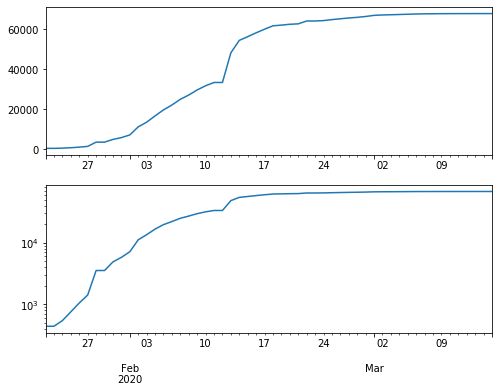

In [5]:
#Quick visualization of the case data first on a linear y scale, then on a logarithmic y scale
# Create figure with 8x6 size
fig = plt.figure(figsize=(8,6))

# Create first subplot and draw the linear y-scale curve on it
axA = plt.subplot(211)
linplot = caseData.plot(kind='line')

# Create the second subplot with a logarithmic y-scale below the first subplot
axB = plt.subplot(212)
logplot = caseData.plot(kind='line',logy=True)

plt.show()

Note: Per documentation, there's a change in measurement on Feb 14th; switched from counting only lab-confirmed cases to lab-confirmed and clinically diagnosed. This causes an artificial spike in cases

In [6]:
prcntChange = pd.Series(dtype='float64').reindex_like(caseData)

In [7]:
ecount = 0
n = 0
for index,value in caseData.iteritems():
    #Skips first iteration because there are no values before the first item of the series
    if n == 0:
        n+=1
        continue
    try:
        prcntChange.iat[n] = (value/caseData.iat[n-1])*100
    except ValueError or KeyError:
        print('error calculating percent change for',index)
        ecount += 1
    finally:
        n+=1
        print(prcntChange[index])
        
print(prcntChange.head())
    


100.0
123.64864864864865
138.61566484517306
139.0275952693824
134.4990548204159
249.75404075895992
100.0
137.9572312886888
118.41729553334692
123.20013778849466
156.25611631483295
120.98058513017804
123.33974264162106
117.90982132150138
112.44342740910247
112.84822720694645
108.60417585059912
109.33948339483395
107.07704768654449
105.1626323751891
100.0
144.47641311514715
112.86146952661495
103.38749402639415
103.43650553787623
103.10577154446392
102.82218406707896
100.56580525923285
100.66257193983654
100.35232695941833
102.26931792793081
100.0
100.31677173709505
100.77620669808826
100.6189608866113
100.62742571371592
100.48478565766206
100.64174530448766
100.85924898623695
100.29294393710673
100.16988808250005
100.17108767127363
100.19901384185826
100.18676073874249
100.10948041188306
100.06059172996777
100.0531702778147
100.02509484374768
100.01918536009444
100.01180411078158
100.00737669848483
100.00590092349452
100.0059005753061
2020-01-22           NaN
2020-01-23    100.000000
20

In [8]:
# Replace 1.0 percent change values with NaN as it's a reasonable assumption that changes in total cases
# were present but simply failed to be captured on these dates.
prcntChange = prcntChange.mask(lambda x: x == 100)
print(prcntChange.index)
#Remaking the series into a dataframe object because calling a series index into Matplotlib was causing
#errors
prcntChange = pd.DataFrame({'date':prcntChange.index,'change':prcntChange.values})

DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02',
               '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06',
               '2020-02-07', '2020-02-08', '2020-02-09', '2020-02-10',
               '2020-02-11', '2020-02-12', '2020-02-13', '2020-02-14',
               '2020-02-15', '2020-02-16', '2020-02-17', '2020-02-18',
               '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22',
               '2020-02-23', '2020-02-24', '2020-02-25', '2020-02-26',
               '2020-02-27', '2020-02-28', '2020-02-29', '2020-03-01',
               '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05',
               '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09',
               '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13',
               '2020-03-14', '2020-03-15'],
              dtype='datetime64[n

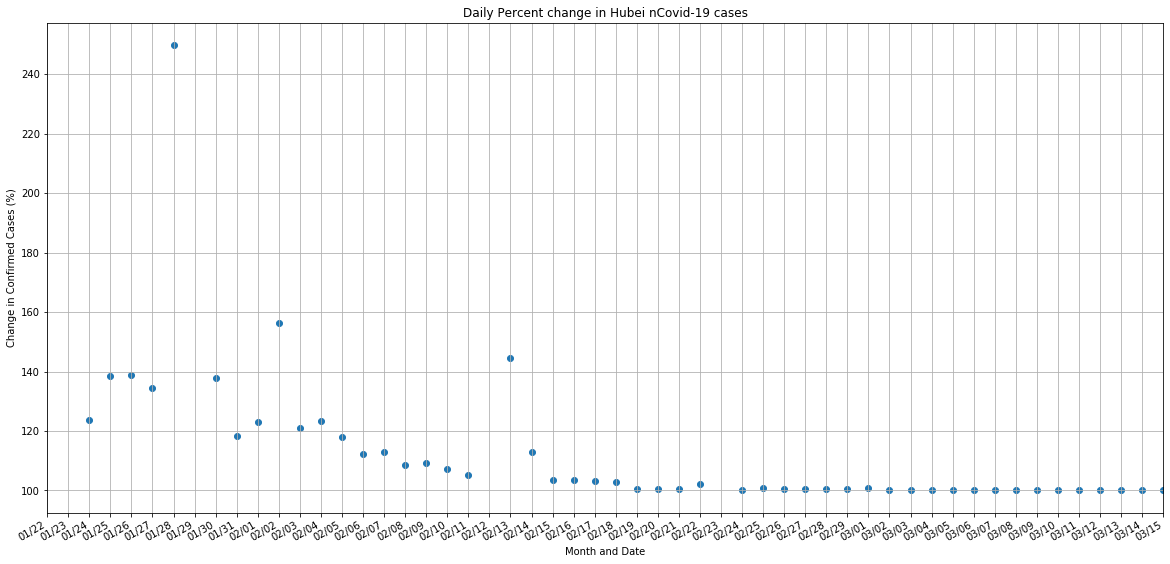

In [9]:
#These objects will be used to place major ticks for each month and minor ticks for each day
days = mpl.dates.DayLocator()
months = mpl.dates.MonthLocator()
#This creates month/day labels
days_format = mpl.dates.DateFormatter('%m/%d')

figure, ax = plt.subplots()
ax.scatter(prcntChange['date'],prcntChange['change'])
ax.set_title('Daily Percent change in Hubei nCovid-19 cases')
ax.set_ylabel('Change in Confirmed Cases (%)')
ax.set_xlabel('Month and Date')

ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(days_format)
ax.xaxis.set_minor_locator(days)

#Sets the width of the plot to map with the date range
ax.set_xlim(prcntChange['date'][0],prcntChange['date'][prcntChange.shape[0]-1])

#Adds major gridlines
ax.grid(True)

#Automatically raises the bottom of the figure and fits dates for readability
figure.autofmt_xdate()
figure.set_figwidth(20)
figure.set_figheight(10)

plt.show()

## Part 2: Collecting and aggregating average regional climate data from multiple weather stations' readings

This part entails downloading weather station files from NOAA's File Transfer Protocol server. For the sake of simplicity (and through that, reproducibility of analysis) I have manually listed the weather station IDs within Hubei even though I have a much longer script for finding the weather stations within a given geographic boundary using coordinate data which fed into this script.

In [10]:
# List of ID numbers of the weather stations within the Hubei region of China
stationIDs = ['573780-99999','574470-99999','572790-99999','573990-99999','572650-99999',
              '574760-99999','572590-99999','574940-99999','574610-99999']

In [11]:
gsodpaths = []
def getPaths(stringinput):
    """
    Helper function which generates a list of the full file names from the FTP server by checking them
    against the list of formatted weather station IDs
    """
    for id in stationIDs:
        if stringinput.startswith(id):
            print(stringinput)
            gsodpaths.append(stringinput)
            
def dlGsod(stringinput):
    """
    Takes a file name from the FTP server as input and downloads the corresponding datafile if
    one of the target station IDs is in the beginning of the filename. Also logs the file's domain
    :param stringinput:
    :return:
    """
    # This creates a /climate directory relative to the current working directory where the climate data
    # files will be output
    CWD = os.getcwd()
    print('using current working directory',CWD,'to create an output directory /climate')
    try:
        os.mkdir(CWD+'/climate')
    except FileExistsError:
        print('climate directory already exists, continuing')
        
    dllogpath = CWD+'/climate'+'/dllog.txt'
    print('attempting to log downloads at',dllogpath)
    for id in stationIDs:
        if stringinput.startswith(id):
            # Checks if the dllog text file already exists. If so, download URL is appended rather than overwritten
            if os.path.isfile(dllogpath):
                dllog = open(dllogpath, 'a')
                outputPath = CWD+ '/climate/' + stringinput
                print('Appending download path into dllog.txt')
                dllog.write('\nftp.ncdc.noaa.gov/pub/data/gsod/2020/'+stringinput)
                noaaFTP.retrbinary('RETR '+stringinput, open(outputPath,'wb').write)
            # This creates the log file and writes the first download URL
            else:
                dllog = open(dllogpath, 'w')
                outputPath = CWD+ '/climate/' + stringinput
                print('Created dllog.txt at',dllogpath)
                dllog.write('ftp.ncdc.noaa.gov/pub/data/gsod/2020/' + stringinput)
                noaaFTP.retrbinary('RETR ' + stringinput, open(outputPath, 'wb').write)

    dllog.close()

In [12]:
# Opens FTP connection with the NCDC NOAA Global Summary of the Day database
password = input('Please enter your UMBC email address')

noaaFTP = FTP('ftp.ncdc.noaa.gov',user='ftp',passwd=password)

# Changes working directory to the 2020 data files
noaaFTP.cwd('./pub/data/gsod/2020/')

# Lists every file in the current directory and runs them as an input into getPaths, which results in a list
# of the filenames for the data from the target weather stations in gsodpaths
noaaFTP.retrlines('NLST',callback=getPaths)

# Iterates over gsodpaths to download the data files from the FTP server
for path in gsodpaths:
    dlGsod(path)

noaaFTP.quit()

Please enter your UMBC email addressawachsm1@umbc.edu
573780-99999-2020.op.gz
574470-99999-2020.op.gz
572790-99999-2020.op.gz
573990-99999-2020.op.gz
572650-99999-2020.op.gz
574760-99999-2020.op.gz
572590-99999-2020.op.gz
574940-99999-2020.op.gz
574610-99999-2020.op.gz
using current working directory /home/dreadpirate to create an output directory /climate
attempting to log downloads at /home/dreadpirate/climate/dllog.txt
Created dllog.txt at /home/dreadpirate/climate/dllog.txt
using current working directory /home/dreadpirate to create an output directory /climate
climate directory already exists, continuing
attempting to log downloads at /home/dreadpirate/climate/dllog.txt
Appending download path into dllog.txt
using current working directory /home/dreadpirate to create an output directory /climate
climate directory already exists, continuing
attempting to log downloads at /home/dreadpirate/climate/dllog.txt
Appending download path into dllog.txt
using current working directory /home

'221 Goodbye.'

In [13]:
def unpackWeatherStations(path):
    # Store cwd to return to it after execution, then change working directory to path
    CWD = os.getcwd()
    os.chdir(path)

    # Put every .gz filename in a list
    fileList = []
    for file in os.listdir(path):
        if file.endswith('.gz'):
            fileList.append(file)

    # Default sort the file list by name
    fileList.sort()

    for index, file in enumerate(fileList):

        with gzip.open(file, 'rt') as f:
            unzipped = pd.read_fwf(f,
                                   # Manually specify the column dimensions because pandas was failing to
                                   # properly infer them.
                                   colspecs=[(0, 6), (7, 12), (14, 22), (24, 30), (31, 33),
                                             (35, 41), (42, 44), (46, 52), (53, 55), (57, 63),
                                             (64, 66), (64, 66), (68, 73), (74, 76), (78, 83),
                                             (84, 86), (88, 93), (95, 100), (102, 108), (108, 109),
                                             (110, 116), (116, 117), (118, 123), (123, 124), (125, 130),
                                             (132, 138)],
                                   # Manually specify data types for the same reason
                                   dtype={'STN---': object, 'WBAN': object,
                                          'YEARMODA': object, 'TEMP': 'float64',
                                          'DEWP': 'float64', 'SLP': 'float64', 'STP': 'float64',
                                          'VISIB': 'float64', 'WDSP': 'float64', 'MXSPD': 'float64',
                                          'GUST': 'float64', 'MAX': 'float64', 'MIN': 'float64',
                                          'PRCP': 'float64', 'SNDP': 'float64', 'FRSHTT': object
                                          })
            f.close()

        # Subsets data down to rows between Jan 1st to March 15th and retains only columns relevant to analysis
        unzipped = unzipped.loc[0:74,['STN---','WBAN','YEARMODA','TEMP','DEWP','MAX','MIN']]
        # Change YEARMODA to pandas timestamp datatype and makes the date the index
        unzipped['YEARMODA'] = pd.to_datetime(unzipped['YEARMODA'], format='%Y%m%d')
        unzipped.set_index('YEARMODA',inplace=True)
        # Replaces stand-in values for missing data with standard NaNs
        unzipped.mask(lambda x: x == 999.9, inplace=True)
        unzipped.mask(lambda x: x == 99.99, inplace=True)
        unzipped.mask(lambda x: x == 9999.9, inplace=True)
        # Assigns newly formed dataframe in-place to list fileList
        fileList[index] = unzipped
        print('successfully read',file,'into list at index',index)

    # Returns to original working directory before terminating
    os.chdir(CWD)
    return fileList

weatherStations = unpackWeatherStations(os.getcwd()+'/climate')


successfully read 572590-99999-2020.op.gz into list at index 0
successfully read 572650-99999-2020.op.gz into list at index 1
successfully read 572790-99999-2020.op.gz into list at index 2
successfully read 573780-99999-2020.op.gz into list at index 3
successfully read 573990-99999-2020.op.gz into list at index 4
successfully read 574470-99999-2020.op.gz into list at index 5
successfully read 574610-99999-2020.op.gz into list at index 6
successfully read 574760-99999-2020.op.gz into list at index 7
successfully read 574940-99999-2020.op.gz into list at index 8


In [14]:
#Creates a new dataframe with the same datetime indices and drops redundant columns
avgDF = pd.DataFrame().reindex_like(weatherStations[0])
avgDF = avgDF.drop('STN---', axis=1)
avgDF = avgDF.drop('WBAN',axis=1)

#Averages temperature, dew point, max temperature, and min temperature by day across each of the nine
#weather station dataframes and excludes missing values from the calculation.
for date in avgDF.index:
    for station in weatherStations:
        iter = []

        avgDF.loc[date, 'TEMP'] = np.nanmean([station.at[date, 'TEMP'] for station in weatherStations])
        avgDF.loc[date, 'DEWP'] = np.nanmean([station.at[date, 'DEWP'] for station in weatherStations])
        avgDF.loc[date, 'MAX'] = np.nanmean([station.at[date, 'MAX'] for station in weatherStations])
        avgDF.loc[date, 'MIN'] = np.nanmean([station.at[date, 'MIN'] for station in weatherStations])

        
print(avgDF.head(20))

                 TEMP       DEWP        MAX        MIN
YEARMODA                                              
2020-01-01  38.922222  28.433333  43.833333  31.633333
2020-01-02  41.544444  33.311111  44.622222  35.744444
2020-01-03  42.655556  36.988889  45.366667  37.411111
2020-01-04  45.155556  40.222222  48.700000  40.177778
2020-01-05  44.233333  42.900000  49.288889  40.500000
2020-01-06  39.588889  38.687500  46.588889  36.655556
2020-01-07  41.511111  37.588889  48.666667  35.088889
2020-01-08  37.177778  35.200000  48.744444  33.144444
2020-01-09  36.011111  34.366667  40.844444  33.455556
2020-01-10  37.211111  35.888889  38.722222  34.166667
2020-01-11  40.100000  35.522222  46.500000  32.588889
2020-01-12  41.133333  36.188889  49.277778  32.711111
2020-01-13  41.511111  36.533333  48.777778  34.166667
2020-01-14  40.411111  31.133333  46.666667  34.844444
2020-01-15  34.288889  31.922222  46.311111  33.088889
2020-01-16  36.600000  30.888889  41.600000  32.000000
2020-01-17

In [15]:
avgDF.insert(loc=0,column='YEARMODA',value=avgDF.index)

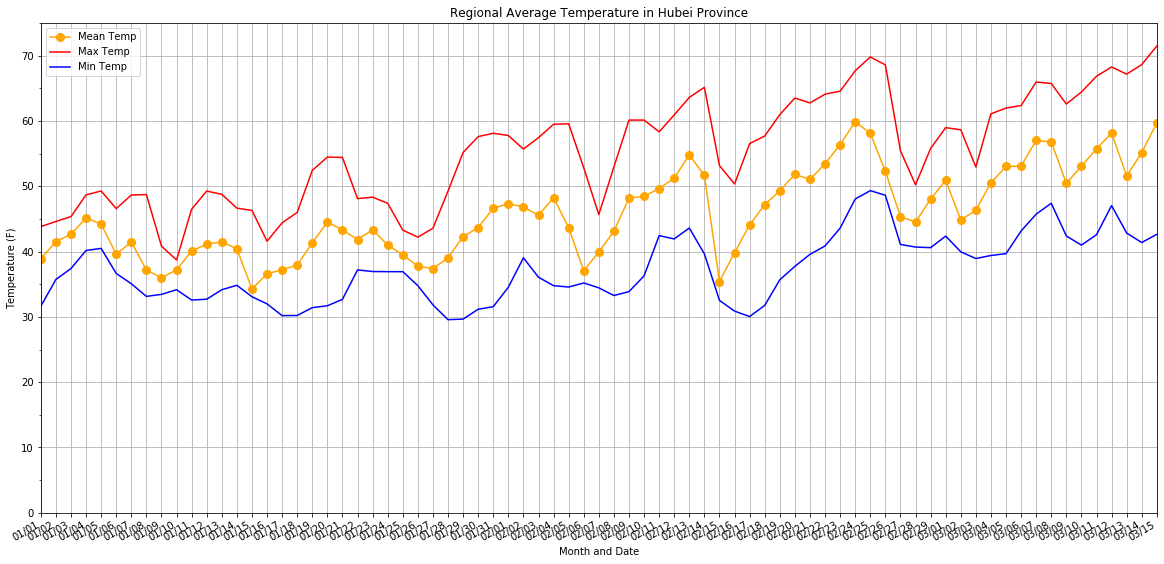

In [16]:
#These objects will be used to place major ticks for each month and minor ticks for each day
days = mpl.dates.DayLocator()
months = mpl.dates.MonthLocator()
#This creates month/day labels
days_format = mpl.dates.DateFormatter('%m/%d')

figure, ax = plt.subplots()
#Plot average mean temp, average maximum temp, and average minimum temp
ax.plot(avgDF['YEARMODA'],avgDF['TEMP'],color='orange',marker='.',markersize='16')
ax.plot(avgDF['YEARMODA'],avgDF['MAX'],color='red')
ax.plot(avgDF['YEARMODA'],avgDF['MIN'],color='blue')
ax.set_title('Regional Average Temperature in Hubei Province')
ax.set_ylabel('Temperature (F)')
ax.set_xlabel('Month and Date')

ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(days_format)
ax.xaxis.set_minor_locator(days)

ax.set_yticks(range(5,80,10),minor = True)

#Sets the width of the plot to map with the date range
ax.set_xlim(avgDF['YEARMODA'][0],avgDF['YEARMODA'][avgDF.shape[0]-1])
ax.set_ylim(0,75)

#Adds major gridlines
ax.grid(True)

ax.legend(['Mean Temp','Max Temp','Min Temp'])

#Automatically raises the bottom of the figure and fits dates for readability
figure.autofmt_xdate()
figure.set_figwidth(20)
figure.set_figheight(10)

plt.show()

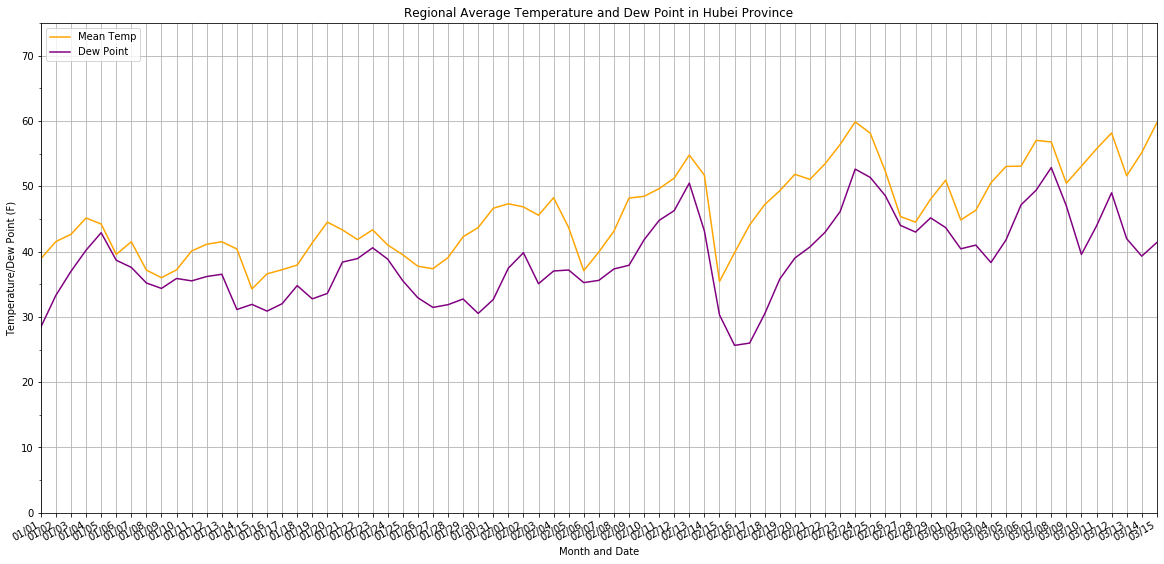

In [17]:
#These objects will be used to place major ticks for each month and minor ticks for each day
days = mpl.dates.DayLocator()
months = mpl.dates.MonthLocator()
#This creates month/day labels
days_format = mpl.dates.DateFormatter('%m/%d')

figure, ax = plt.subplots()
#Plot average mean temp and dew point. Dew point varies quite a bit hourly, but can roughly assume that days
#with a smaller difference between mean temp and dew point were more humid
ax.plot(avgDF['YEARMODA'],avgDF['TEMP'],color='orange')
ax.plot(avgDF['YEARMODA'],avgDF['DEWP'],color='purple')
ax.set_title('Regional Average Temperature and Dew Point in Hubei Province')
ax.set_ylabel('Temperature/Dew Point (F)')
ax.set_xlabel('Month and Date')

ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(days_format)
ax.xaxis.set_minor_locator(days)

ax.set_yticks(range(5,80,10),minor = True)

#Sets the width of the plot to map with the date range and set the y-axis scale to start from 0
ax.set_xlim(avgDF['YEARMODA'][0],avgDF['YEARMODA'][avgDF.shape[0]-1])
ax.set_ylim(0,75)

#Adds major gridlines
ax.grid(True)
ax.legend(['Mean Temp','Dew Point'],loc='upper left')

#Automatically raises the bottom of the figure and fits dates for readability
figure.autofmt_xdate()
figure.set_figwidth(20)
figure.set_figheight(10)

plt.show()

## Part 3: Analyzing relationship between Average Temperature, Dew Point, and Percent Change in Cases

In [19]:
# Creates a series of points for all dates with a valid prcntChange values
# where x = mean temp and y = percent change in covid cases
tempAndCases = []
for date in prcntChange.index:
    if pd.notna(prcntChange['change'][date]):
        tempAndCases.append((avgDF['TEMP'][date],prcntChange['change'][date]))

In [20]:
# Sort series in ascending order by temperature
tempAndCases = sorted(tempAndCases,key=lambda x: x[0])

In [21]:
tcx = np.array([x[0] for x in tempAndCases])
tcy = np.array([y[1] for y in tempAndCases])

slope, intercept, r_value, p_value, std_err = stats.linregress(tcx,tcy)
print('Linear Regression for Percent Change in nCOVID-19 Cases in terms of Mean Regional Temperature')
print('Correlation Coefficient (r)',r_value)
print('Coefficient of Determination (R**2):',r_value**2)
print('Formula: y = {}x + {}'.format(round(slope,3),round(intercept,3)))
print('p =',p_value)

Linear Regression for Percent Change in nCOVID-19 Cases in terms of Mean Regional Temperature
Correlation Coefficient (r) -0.24619780603913038
Coefficient of Determination (R**2): 0.060613359698481264
Formula: y = -1.105x + 160.723
p = 0.0881471938970286


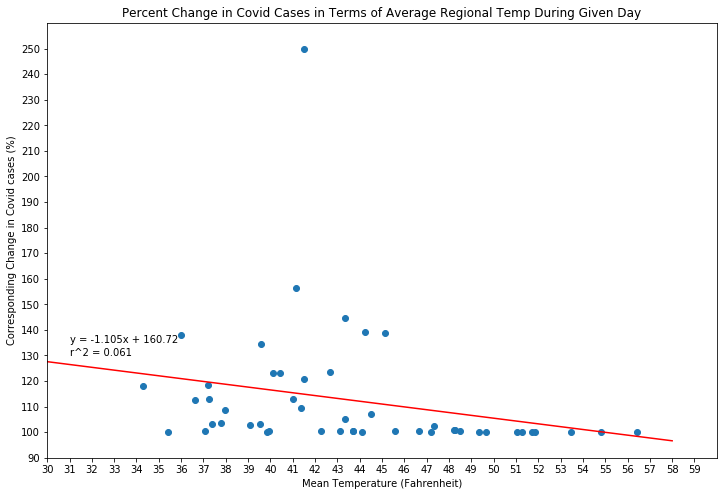

In [22]:
figure, ax = plt.subplots()
#Plot average mean temp and dew point. Dew point varies quite a bit hourly, but can roughly assume that days
#with a smaller difference between mean temp and dew point were more humid
ax.scatter(x=tcx,y = tcy)
#Plot linear regression
ax.plot(range(30,60,2),[(x*slope)+intercept for x in range(30,60,2)],color='red')

ax.set_title('Percent Change in Covid Cases in Terms of Average Regional Temp During Given Day')
ax.set_ylabel('Corresponding Change in Covid cases (%)')
ax.set_xlabel('Mean Temperature (Fahrenheit)')
#Label regression line with formula and r^2 value
ax.text(31,135,'y = {}x + {}'.format(round(slope,3),round(intercept,2),))
ax.text(31,130,'r^2 = {}'.format(round(r_value**2,3)))

ax.set_xlim(30,60)
ax.set_xticks(range(30,60,1))
ax.set_ylim(90,260)
ax.set_yticks(range(90,260,10))

figure.set_figwidth(12)
figure.set_figheight(8)

In [23]:
print('The maximum y value is',(stats.tmax(tcy)-stats.tmean(tcy))/stats.tstd(tcy),'standard deviations above the mean')

The maximum y value is 5.586701499819978 standard deviations above the mean


In [24]:
#Remake the scatterplot removing the maximum outlier
tempAndCases = []
for date in prcntChange.index:
    if pd.notna(prcntChange['change'][date]) and prcntChange['change'][date] < 240:
        tempAndCases.append((avgDF['TEMP'][date],prcntChange['change'][date]))
        
# Sort series in ascending order by temperature
tempAndCases = sorted(tempAndCases,key=lambda x: x[0])

tcx = np.array([x[0] for x in tempAndCases])
tcy = np.array([y[1] for y in tempAndCases])

slope, intercept, r_value, p_value, std_err = stats.linregress(tcx,tcy)
print('Linear Regression for Percent Change in nCOVID-19 Cases in terms of Mean Regional Temperature')
print('Correlation Coefficient (r)',r_value)
print('Coefficient of Determination (r**2):',r_value**2)
print('Formula: y = {}x + {}'.format(round(slope,3),round(intercept,3)))
print('p =',p_value)

Linear Regression for Percent Change in nCOVID-19 Cases in terms of Mean Regional Temperature
Correlation Coefficient (r) -0.34919837005335086
Coefficient of Determination (r**2): 0.12193950164791696
Formula: y = -0.91x + 149.422
p = 0.014988054388130992


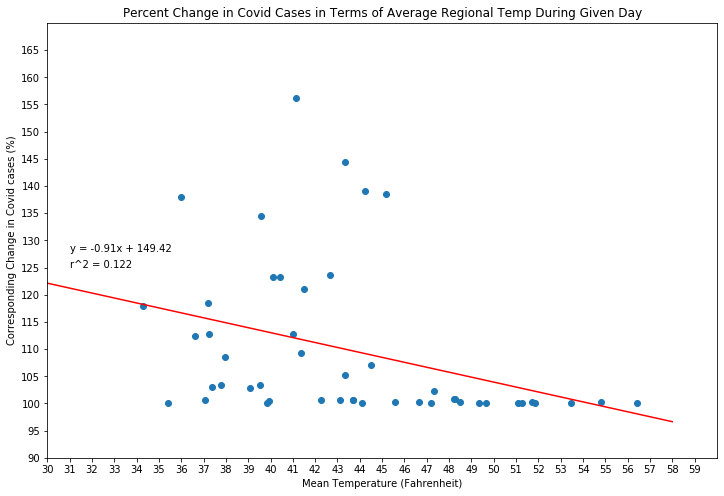

In [25]:
figure, ax = plt.subplots()
#Plot average mean temp and dew point. Dew point varies quite a bit hourly, but can roughly assume that days
#with a smaller difference between mean temp and dew point were more humid
ax.scatter(x=tcx,y = tcy)
#Plot linear regression
ax.plot(range(30,60,2),[(x*slope)+intercept for x in range(30,60,2)],color='red')

ax.set_title('Percent Change in Covid Cases in Terms of Average Regional Temp During Given Day')
ax.set_ylabel('Corresponding Change in Covid cases (%)')
ax.set_xlabel('Mean Temperature (Fahrenheit)')
#Label regression line with formula and r^2 value
ax.text(31,128,'y = {}x + {}'.format(round(slope,3),round(intercept,2),))
ax.text(31,125,'r^2 = {}'.format(round(r_value**2,3)))

ax.set_xlim(30,60)
ax.set_xticks(range(30,60,1))
ax.set_ylim(90,170)
ax.set_yticks(range(90,170,5))

figure.set_figwidth(12)
figure.set_figheight(8)

Hypothesis 1: Based on the p value of < 0.05 for the linear model, the correlation coefficient, and the coefficient of determination, the percent change in nCOVID-19 cases appears to have a statistically significant correlation with Mean Regional Temperature, although based on the coefficient of determination this relationship does not account for much of the data's variance

In [26]:
#Permanently drop outlier data point for subsequent analyses
prcntChange = prcntChange.drop(6)

In [27]:
dewpAndCases = []
for date in prcntChange.index:
    if pd.notna(prcntChange['change'][date]):
        dewpAndCases.append(((avgDF['TEMP'][date]-avgDF['DEWP'][date]),prcntChange['change'][date]))
        
# Sort series in ascending order by temp-dewpoint
dewpAndCases = sorted(dewpAndCases,key=lambda x: x[0])

In [28]:
dcx = np.array([x[0] for x in dewpAndCases])
dcy = np.array([y[1] for y in dewpAndCases])

slope, intercept, r_value, p_value, std_err = stats.linregress(dcx,dcy)
print('Linear Regression for Percent Change in nCOVID-19 Cases in terms of daily Avg Temp - Avg Dew Point')
print('Correlation Coefficient (r)',r_value)
print('Coefficient of Determination (R**2):',r_value**2)
print('Formula: y = {}x + {}'.format(round(slope,3),round(intercept,3)))
print('p =',p_value)

Linear Regression for Percent Change in nCOVID-19 Cases in terms of daily Avg Temp - Avg Dew Point
Correlation Coefficient (r) -0.5138853023162019
Coefficient of Determination (R**2): 0.2640781039366142
Formula: y = -1.734x + 122.243
p = 0.00018709185928405725


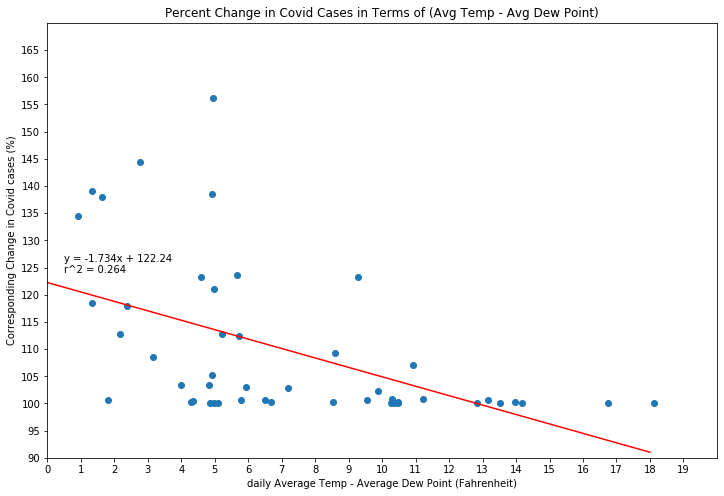

In [29]:
figure, ax = plt.subplots()
#Plot average mean temp and dew point. Dew point varies quite a bit hourly, but can roughly assume that days
#with a smaller difference between mean temp and dew point were more humid
ax.scatter(x=dcx,y = dcy)
#Plot linear regression
ax.plot(range(0,20,2),[(x*slope)+intercept for x in range(0,20,2)],color='red')

ax.set_title('Percent Change in Covid Cases in Terms of (Avg Temp - Avg Dew Point)')
ax.set_ylabel('Corresponding Change in Covid cases (%)')
ax.set_xlabel('daily Average Temp - Average Dew Point (Fahrenheit)')
#Label regression line with formula and r^2 value
ax.text(0.5,126,'y = {}x + {}'.format(round(slope,3),round(intercept,2),))
ax.text(0.5,124,'r^2 = {}'.format(round(r_value**2,3)))

ax.set_xlim(0,20)
ax.set_xticks(range(0,20,1))
ax.set_ylim(95,170)
ax.set_yticks(range(90,170,5))

figure.set_figwidth(12)
figure.set_figheight(8)

Hypothesis 2: The p-value below 0.01 and larger r^2 suggest that this linear model fits the data better than the Average Temperature model. Surprisingly, however, the percent change in nCOVID-19 cases correlates negatively with (Avg Temp - Avg Dew Point), suggesting that higher humidity may have been associated with greater relative increases in nCOVID-19 cases. This is the opposite of the relationship I predicted.

In [30]:
multivarCases = []
for date in prcntChange.index:
    if pd.notna(prcntChange['change'][date]):
        multivarCases.append((avgDF['TEMP'][date],(avgDF['TEMP'][date]-avgDF['DEWP'][date]),prcntChange['change'][date]))
        
# Sort series in ascending order by average temperature
multivarCases = sorted(multivarCases,key=lambda x: x[0])

#Create an array of avg_temp, avg_temp-avg_dewpoint pairs
mvx = []
for case in multivarCases:
    mvx.append([case[0],case[1]])
mvx = np.array(mvx)
#Add a constant column to the array so that statsmodels will calculate intercept
mvx = sm.add_constant(mvx)

#Create array of dependent variable
mvy = np.array([y[2] for y in multivarCases])

#Generate model and calculate multivariate linear regression
multivarModel = sm.OLS(mvy,mvx)
results = multivarModel.fit()

In [31]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     8.705
Date:                Sat, 04 Apr 2020   Prob (F-statistic):           0.000637
Time:                        04:21:55   Log-Likelihood:                -187.73
No. Observations:                  48   AIC:                             381.5
Df Residuals:                      45   BIC:                             387.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        136.3600     15.076      9.045      0.0

Hypothesis 3: The p-value for the multivariate model is slightly greater than that of the temp-dewpoint differential univariate model, but still well below .01. R^2 is slightly higher than that of the temp-dewpoint differential model suggesting a slightly better fit and explanation of variance. Notably, temp-dewpoint differential still has a negative coefficient in the multivariate model, once again suggesting that there seem to be smaller relative increases in nCOVID-19 cases on less humid days. While average regional temperature and humidity do seem to relate to daily changes in nCOVID-19 cases based on this model, my specific hypotheses about the influence of humidity were incorrect

## Conclusion:
Although the results of these linear regressions suggest significant negative correlation between warmer average temperatures, greater average temperature-average dew point differentials, and relative changes in total nCOVID-19 cases, there are three major flaws in my analysis that require further data or modeling changes.


First, the Chinese government began escalating its response to the pandemic during the period of time I analyzed, which also happens to correspond with the end of winter. Without further data to separate the effects of public health measures, one cannot draw strong conclusions from this analysis.


Second, I used linear regression models in these analyses, but the shapes of the scatterplots are ambiguous. Other types of regression models may fit the data better.


Last, as I mentioned earlier, the counting method for nCOVID-19 cases expands after February 14th, however I analyzed the whole time series in aggregate. Further analysis may benefit from splitting the case data into two time series before and after that date.


Due to these shortcomings in the analysis, I must conclude that the relationship between these climate variables and the spread of nCOVID-19 remains inconclusive.